In [36]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from utils.class_weights import get_normalized_class_weights
from utils.model_evaluate import ModelEvaluator

from sklearn.metrics import precision_score, recall_score

In [47]:
def plot_th_decision(model, X, y, th_atual=0.5):
    # Obter probabilidades do modelo
    y_probas = model.predict_proba(X)[:, 1]

    # Criar thresholds de 0.05 em 0.05
    thresholds = np.arange(0.26, 0.6, 0.02)

    # Calcular precision e recall para cada threshold
    precisions = []
    recalls = []

    for th in thresholds:
        y_pred = (y_probas > th).astype(int)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        precisions.append(precision)
        recalls.append(recall)

    # Criar DataFrame com os resultados
    df_metrics = pd.DataFrame({
        'Threshold': thresholds,
        'Precision': precisions,
        'Recall': recalls
    })

    # Criar gráfico com Plotly
    fig = go.Figure()

    # Adicionar linha de Precision
    fig.add_trace(go.Scatter(
        x=df_metrics['Threshold'],
        y=df_metrics['Precision'],
        name='Precision',
        line=dict(color='blue', width=2)
    ))

    # Adicionar linha de Recall
    fig.add_trace(go.Scatter(
        x=df_metrics['Threshold'],
        y=df_metrics['Recall'],
        name='Recall',
        line=dict(color='red', width=2)
    ))

    # Atualizar layout
    fig.update_layout(
        title='Precision e Recall vs Threshold',
        xaxis_title='Threshold',
        yaxis_title='Score',
        hovermode='x unified',
        yaxis=dict(range=[0, 1])
    )

    # Adicionar linha vertical no threshold atual (0.45)
    fig.add_vline(x=0.45, line_dash="dash", line_color="gray", annotation_text=f"Threshold Atual ({th_atual})")

    # Mostrar o gráfico
    fig.show()

    # Mostrar os valores em uma tabela
    print("\nValores por Threshold:")
    print(df_metrics.round(3).to_string(index=False))

# Carregamento dos dados

In [2]:
df = pd.read_csv('../data/02_handling_outliers/data.csv')
print(df.shape)

df.head()

(22742, 14)


,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,blog_cartola,cartola_status,horas_engajamento_futebol,horas_engajamento_outros_esportes,horas_engajamento_home
0,1919933,NaN,NaN,NaN,1,1,1,0.012500,m_only,0.012500,cartola_free,0.000000,0.000000,0.000000
1,1979452,NaN,NaN,NaN,7,66,10,1.018757,pc_e_m,0.068122,cartola_pro,0.911605,0.000000,0.026530
2,1987950,NaN,NaN,NaN,7,14,6,1.293761,pc_e_m,0.012500,cartola_free,0.000000,0.564663,0.025642
3,1988149,NaN,NaN,NaN,8,49,24,1.995802,pc_only,0.013103,cartola_free,0.357694,0.961152,0.651353
4,1996199,NaN,NaN,NaN,21,75,46,2.845341,pc_e_m,0.026424,cartola_free,0.335683,1.996365,0.219123


Atribuindo labels ao target

In [3]:
df.loc[df['cartola_status'] == 'cartola_free', 'target_cartola_status'] = 0
df.loc[df['cartola_status'] == 'cartola_pro', 'target_cartola_status'] = 1
df.drop(columns=['cartola_status'], inplace=True)

# Preparação dos dados

## Correlação e Feature Engineering

Analisando distribuição do target

In [4]:
df['target_cartola_status'].value_counts(normalize=True) * 100

target_cartola_status
0.0    97.388093
1.0     2.611907
Name: proportion, dtype: float64

Vamos utilizar a correlação de Spearman, pois ela captura relações monotônicas (não apenas lineares) e é mais robusta a outliers

<Axes: >

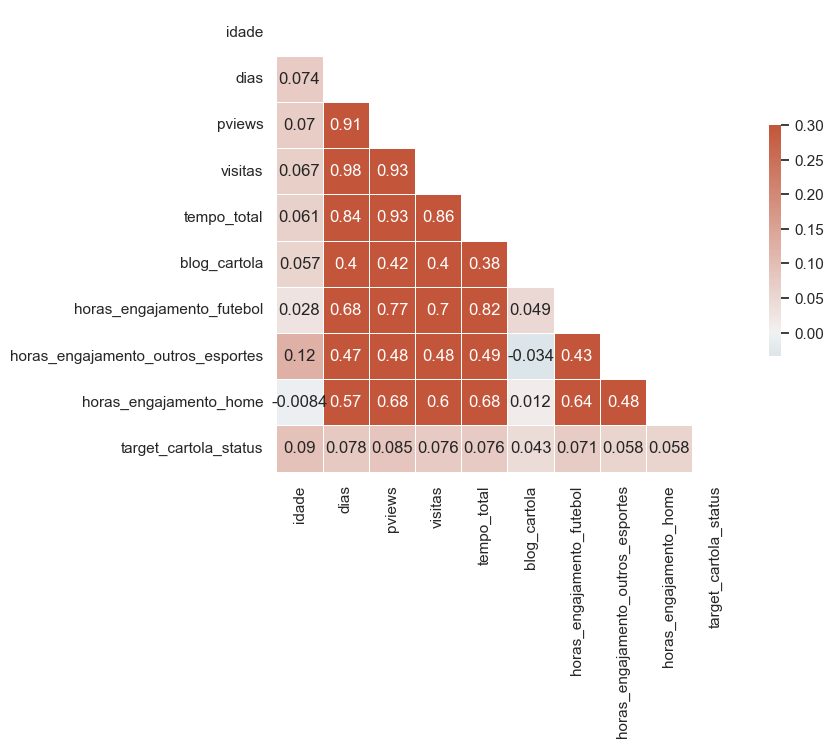

In [5]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Temos muitas features altamente correlatas, vamos reduzir algumas para evitar possível multicolinearidade

In [6]:
# taxa de engajamento
df['taxa_engajamento'] = df['tempo_total'] / df['visitas']

# razão entre a qtd de pviews por visitas
df['pviews_por_visitas'] = df['pviews'] / df['visitas']

# frequencia de visitas
df['frequencia_visitas'] = df['visitas'] / df['dias']

Dropando colunas que não serão mais utilizadas

- coluna UF: Como vimos na análise exploratória, se não há diferença significativa na distribuição de clientes PRO e Free, a variável adiciona ruído sem valor preditivo
Também vamos evitar o problema de criar muitas variáveis dummy.
- coluna devices: vamos retirá-la, pois seu número de missings representa 50% do dataframe, o que pode comprometer a análise, até mesmo na hora de preenchê-los.
- coluna sexo: vimos na análise exploratória que o sexo masculino é predominante, e tbm notamos o alto nível de missing. Nessa primeira etapa, vou retirar essa variável,
  porém, vale a pena testa-la de outras formas futuramente, como por exemplo, imputar os valores nulos com um valor numérico (ex: -1) ou uma categoria representativa ('nao_atribuido').


In [7]:
drop_cols = ['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device']
# drop_cols = ['uf', 'device']

df = df.drop(columns=drop_cols)

<Axes: >

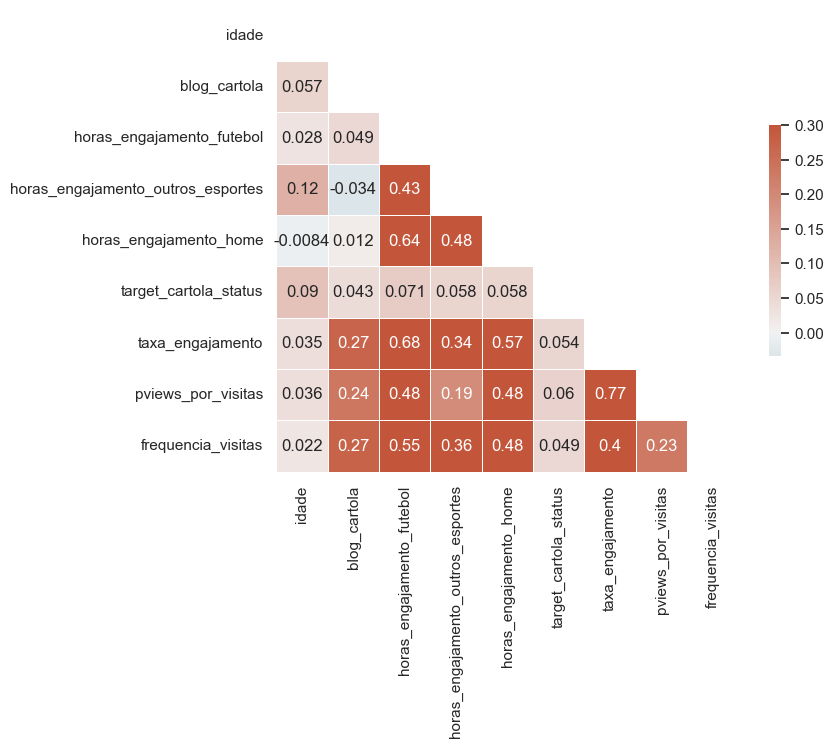

In [8]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Houve uma boa redução na correlação das variáveis.

## Split em treino, validação e teste

In [9]:
df_test = df.sample(frac=.2, random_state=42) # separando 20% para teste

df_train_val = df.drop(df_test.index)

In [10]:
df_train_val.columns

Index(['user', 'idade', 'blog_cartola', 'horas_engajamento_futebol',
       'horas_engajamento_outros_esportes', 'horas_engajamento_home',
       'target_cartola_status', 'taxa_engajamento', 'pviews_por_visitas',
       'frequencia_visitas'],
      dtype='object')

In [11]:
X = df_train_val.drop(columns=['user', 'target_cartola_status'])
y = df_train_val['target_cartola_status']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Column Transformer

In [13]:
# Define as colunas para cada tipo de transformação
cols_num = [
    'idade',
    'taxa_engajamento',
    'pviews_por_visitas',
    'frequencia_visitas',
    'blog_cartola',
    'horas_engajamento_futebol',
    'horas_engajamento_outros_esportes',
    'horas_engajamento_home',
]


# Pipeline para variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Primeiro trata missing
    ('scaler', StandardScaler())                    # Depois faz a padronização
])

# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Primeiro trata missing
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))            # Depois faz o encoding
])


# Cria o preprocessador completo usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_num),
        # ('cat', categorical_transformer, cols_cat),
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['idade', 'taxa_engajamento',
                                  'pviews_por_visitas', 'frequencia_visitas',
                                  'blog_cartola', 'horas_engajamento_futebol',
                                  'horas_engajamento_outros_esportes',
                                  'horas_engajamento_home'])])

Para avaliar o resultado da saída do pré-processamento, basta descomentar as linhas abaixo:

In [14]:
# # treinando
# df_test_preprocessor = X_val.head().copy()
# preprocessor.fit_transform(X_train)

# # transformação
# test_preprocessor_transformed = preprocessor.transform(df_test_preprocessor)

# df_test_preprocessor_transformed = pd.DataFrame(
#     data=test_preprocessor_transformed,
#     columns=preprocessor.get_feature_names_out()  # Ajuste conforme seu pipeline
# )

# display(df_test_preprocessor)
# display(df_test_preprocessor_transformed)

# Experimentos

Objetivo: Ajustar um modelo preditivo simples para identificar os perfis de usuários propensos a assinarem o 
Cartola

In [15]:

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

c:\Users\victo\Documents\recrutamento_globo\case_tecnico\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def plot_precision_recall_curve(y_true: np.ndarray, y_pred: np.ndarray, title: str = 'Precision-Recall Curve') -> None:
    """
    Plots the precision-recall curve for a binary classification model.

    Parameters:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted probabilities or confidence scores for positive class.
        title (str, optional): Title for the plot. Defaults to 'Precision-Recall Curve'.

    Returns:
        None
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    auc_score = auc(recall, precision)

    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.show()

In [17]:
# Calcula os pesos para os dados de treino
class_weights = get_normalized_class_weights(y_train)
class_weights

{0.0: 0.513041945717307, 1.0: 19.66891891891892}

In [18]:
# calculando o scale pos weights
scale_pos_weight = int(class_weights[1] / class_weights[0])
scale_pos_weight

38

In [19]:
# simples função para chamar o Model Evaluator
def fit_evaluate(model, X_train, y_train, X_val, y_val, th=0.5):
    model.fit(X_train, y_train);

    train_results = ModelEvaluator(model, X_train, y_train, th=th)
    display(train_results.evaluate())

    # Avaliação no conjunto de validação
    val_results = ModelEvaluator(model, X_val, y_val, th=th)
    display(val_results.evaluate())

## Logistic Regression

In [20]:
lr_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=class_weights, 
                max_iter=2000, 
                random_state=42
            ))
        ])

fit_evaluate(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.4,5.1,55.95,993.77,9.35,72.43


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,63.63,5.64,54.72,1008.31,10.23,72.03


In [21]:
lr_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=class_weights, 
                max_iter=2000, 
                random_state=42
            ))
        ])

fit_evaluate(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,66.02,4.68,68.38,1305.55,8.76,63.78


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.42,5.06,66.04,1337.15,9.4,62.9


## Decision Trees

In [22]:
dt_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(dt_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,71.73,5.65,77.03,1200.05,10.52,66.71


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,60.08,4.49,55.66,1288.62,8.32,64.25


In [23]:
dt_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(dt_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,71.0,4.72,88.65,1649.02,8.97,54.25


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,59.18,3.97,66.98,1736.32,7.49,51.83


## RandomForest

In [24]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,73.75,7.4,70.54,836.02,13.39,76.81


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.41,5.73,49.06,901.34,10.26,74.99


In [25]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,74.48,6.21,80.81,1136.16,11.53,68.48


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,66.49,5.65,66.04,1192.54,10.42,66.91


Random forest por enquanto está obtendo os melhores resultados, com o mínimo de mudança nos hiperparâmetros. \
Consigo não reduzir muito a f1 enquanto aumento a recall, em comparação com os outros modelos.

## XGboost

**Utilizando Modelos mais robustos para finalidade de comparação**

Alterando max depth

In [26]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                max_depth=5,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,96.07,35.31,96.76,165.42,51.73,95.41


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,56.24,8.13,18.87,309.03,11.36,91.43


Alterando n estimators

In [27]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                max_depth=5,
                n_estimators=150,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,97.61,55.05,97.3,75.28,70.31,97.91


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,52.02,5.42,8.49,251.58,6.62,93.02


Alterando learning rate

In [28]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                max_depth=5,
                n_estimators=100,
                learning_rate=0.01,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,75.71,5.69,90.54,1382.56,10.71,61.64


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.28,4.6,65.09,1455.02,8.59,59.63


Fica bem complexo chegar ao resultado da random forest sem utilizar alguma ferramenta de tuning de hiperparâmetros.

## LGBM

In [34]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,94.87,27.19,96.49,239.96,42.42,93.34


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,56.09,6.41,21.7,415.01,9.89,88.49


In [36]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,93.86,22.31,96.49,311.03,36.24,91.37


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,56.83,6.08,25.47,491.28,9.82,86.37


In [37]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        n_estimators=150,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,96.14,34.79,97.03,169.38,51.21,95.3


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,54.14,5.84,16.04,359.55,8.56,90.02


In [39]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        max_depth=8,
        n_estimators=100,
        learning_rate=0.01,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42,
        verbose=-1
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,78.79,21.13,63.78,251.35,31.74,93.03


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,55.14,6.57,17.92,353.6,9.62,90.19


## Tunando Modelos com Optuna

### Random Forest

Vamos tunar inicialmente com um modelo mais simples.

In [40]:
import warnings
warnings.filterwarnings('ignore')

DESCOMENTE A CÉLULA ABAIXO CASO QUEIRA FAZER O TUNING DE HIPERPARÂMETROS UTILIZANDO OPTUNA

In [50]:
# def objective(trial):
            
#     # Profundidade da árvore
#     rf_max_depth = trial.suggest_int('max_depth', 5, 15)
    
#     # Quantidade de estimadores
#     rf_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    
#     # Número mínimo de amostras necessárias para dividir um nó, ajudando a controlar o tamanho das árvores.
#     rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
#     # Número mínimo de amostras em uma folha, evitando que a árvore cresça excessivamente.
#     rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    
#     classifier_obj = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', RandomForestClassifier(
#             max_depth=rf_max_depth
#             , n_estimators=rf_n_estimators
#             , class_weight=class_weights))
#     ])
    
#     classifier_obj.fit(X_train, y_train)
    
#     predictions = classifier_obj.predict(X_val)
#     metric = recall_score(y_val, predictions)
    
#     return metric

# # otimizando durante 300 segundos (5 minutos)
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, timeout=300)


[I 2024-10-28 14:39:48,206] A new study created in memory with name: no-name-244799cf-0e5c-4afd-b6f0-9ec430083ed2
[I 2024-10-28 14:39:51,468] Trial 0 finished with value: 0.2169811320754717 and parameters: {'max_depth': 8, 'n_estimators': 312, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.2169811320754717.
[I 2024-10-28 14:40:04,418] Trial 1 finished with value: 0.04716981132075472 and parameters: {'max_depth': 11, 'n_estimators': 939, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2169811320754717.
[I 2024-10-28 14:40:13,010] Trial 2 finished with value: 0.16981132075471697 and parameters: {'max_depth': 9, 'n_estimators': 812, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.2169811320754717.
[I 2024-10-28 14:40:17,084] Trial 3 finished with value: 0.2169811320754717 and parameters: {'max_depth': 8, 'n_estimators': 397, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with val

In [55]:
# best params:
parameters = {'max_depth': 5, 'n_estimators': 702, 'min_samples_split': 20, 'min_samples_leaf': 2}

rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                # **study.best_params,
                **parameters,
                class_weight=class_weights, 
                random_state=42,
            ))
        ])

rf_model.fit(X_train, y_train)
rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.45)
rf_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,65.75,5.43,66.04,1244.05,10.03,65.49


In [78]:
plot_th_decision(rf_model, X_val, y_val, th_atual=0.42)
# o melhor th é 0.42
# descer para 0.4 tem o ganho 0.71 para 0.72 em recall, porém a precision
# cai de 0.05 para 0.046
# subir para 0.44 tem o decaimento de recall em 0.71 para 0.66
# porém o ganho de precision é marginal: 0.05 para 0.051


Valores por Threshold:
 Threshold  Precision  Recall
      0.26      0.034   0.887
      0.28      0.036   0.849
      0.30      0.037   0.802
      0.32      0.038   0.774
      0.34      0.040   0.774
      0.36      0.043   0.774
      0.38      0.045   0.745
      0.40      0.047   0.726
      0.42      0.050   0.717
      0.44      0.052   0.670
      0.46      0.056   0.651
      0.48      0.061   0.613
      0.50      0.060   0.528
      0.52      0.060   0.453
      0.54      0.060   0.377
      0.56      0.062   0.330
      0.58      0.055   0.245


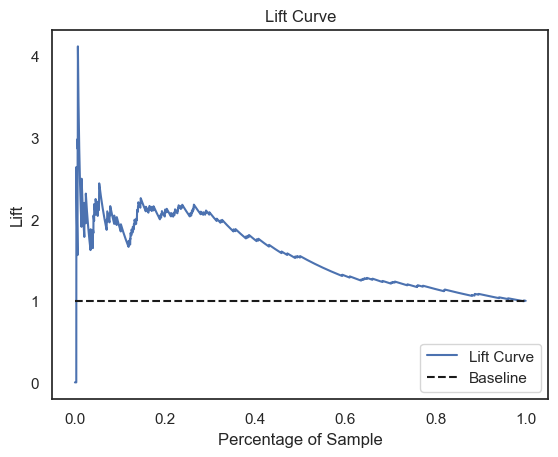

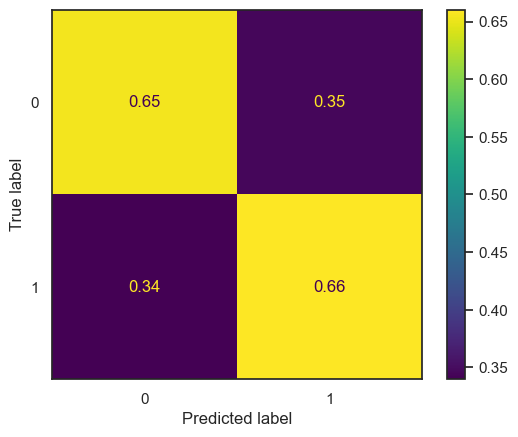

In [57]:
rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

In [58]:
th = 0.45
y_probas = rf_model.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

In [59]:
th = 0.45
y_probas = rf_model.predict_proba(X_val)[:, 1]

# Classify data into low, medium, and high categories
ypred_low = (y_probas <= th).astype(int)
ypred_medium = (y_probas > th) & (y_probas <= 0.7).astype(int)
ypred_high = (y_probas > 0.7).astype(int)

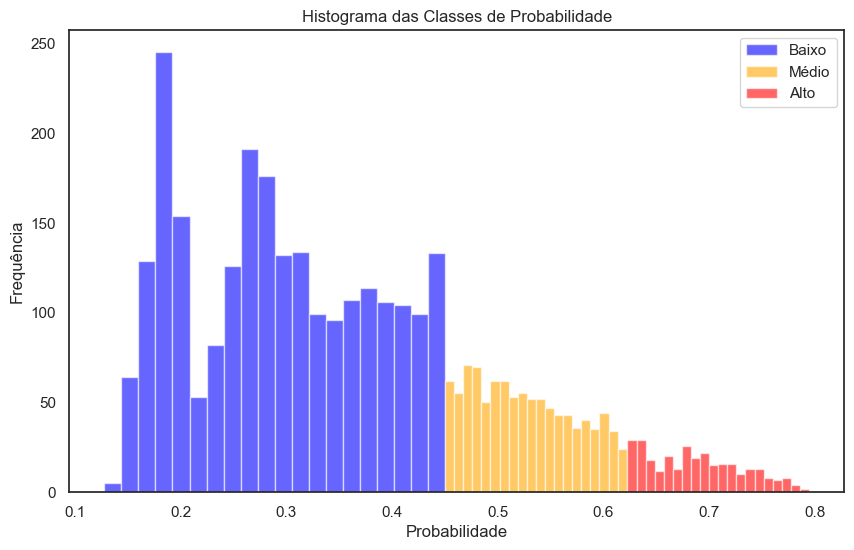

In [60]:
import numpy as np
import matplotlib.pyplot as plt

y_probas = rf_model.predict_proba(X_val)[:, 1]

# Definindo os thresholds para classificação em baixo, médio e alto
th_low = 0.45

# Média entre o threshold baixo e o valor máximo
th_mid = (0.45 + y_probas.max()) / 2  

# Classificando as probabilidades
y_class = np.where(y_probas < th_low, 'baixo', 
                   np.where(y_probas < th_mid, 'médio', 'alto'))

# Plotando o histograma
plt.figure(figsize=(10, 6))
plt.hist(y_probas[y_class == 'baixo'], bins=20, color='blue', alpha=0.6, label='Baixo')
plt.hist(y_probas[y_class == 'médio'], bins=20, color='orange', alpha=0.6, label='Médio')
plt.hist(y_probas[y_class == 'alto'], bins=20, color='red', alpha=0.6, label='Alto')
plt.xlabel("Probabilidade")
plt.ylabel("Frequência")
plt.title("Histograma das Classes de Probabilidade")
plt.legend()
plt.show()


Test

In [61]:
drop_cols

['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device']

In [62]:
X_test = df_test.drop(columns=['user', 'target_cartola_status'])
y_test = df_test['target_cartola_status']

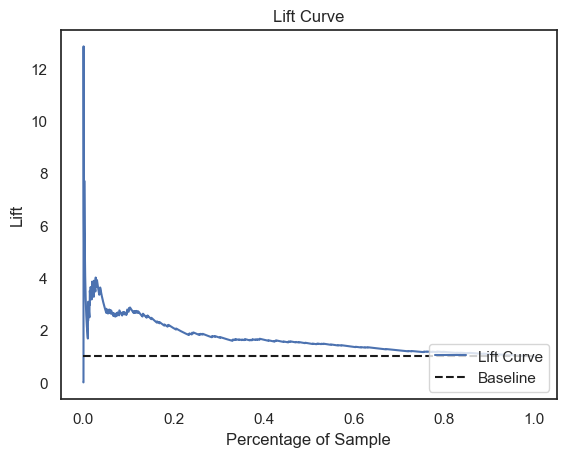

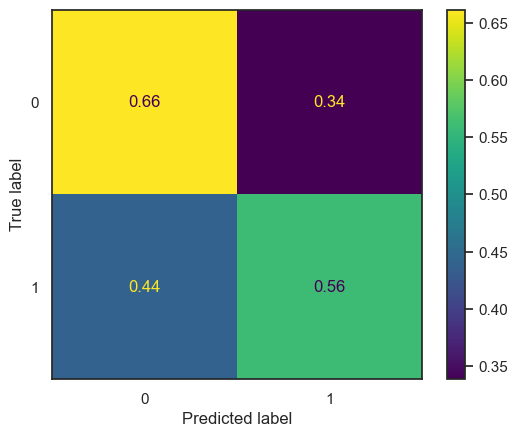

In [65]:
th = 0.45
y_probas = rf_model.predict_proba(X_test)[:, 1]

# Classify data into low, medium, and high categories
ypred_low = (y_probas <= th).astype(int)
ypred_medium = (y_probas > th) & (y_probas <= 0.7).astype(int)
ypred_high = (y_probas > 0.7).astype(int)


rf_eval = ModelEvaluator(rf_model, X_test, y_test, th=th)
rf_eval.evaluate()

rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

### XGBoost

O próximo passo é testar com um modelo mais robusto

In [66]:
# def objective(trial):
#     params = {
#         'objective': 'binary:logistic',  # ou 'multi:softmax' para múltiplas classes
#         'eval_metric': 'logloss',        # Métrica de avaliação
#         'eta': trial.suggest_float('eta', 0.01, 0.3),  # Taxa de aprendizado
#         'max_depth': trial.suggest_int('max_depth', 5, 15),  # Profundidade máxima da árvore
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fração de amostras
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
#         'n_jobs': -1,  # Usar todos os núcleos
#         'scale_pos_weight': trial.suggest_int('scale_pos_weight', 38, 40),
#         'random_state': 42
#     }
    
#     classifier_obj = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', XGBClassifier(**params))
#     ])
    
    
#     # 2. Treine o modelo com os dados de treino
#     classifier_obj.fit(X_train, y_train)
    
#     # 3. Faça previsões e calcule a métrica
#     predictions = classifier_obj.predict(X_val)
#     metric = recall_score(y_val, predictions)
    
#     return metric

# # 4. Crie um objeto de estudo e otimize a função objetivo.
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=250)

In [68]:
# {'eta': 0.04769409406169523,
#  'max_depth': 5,
#  'subsample': 0.9949393655069952,
#  'learning_rate': 0.0025158412731914083,
#  'n_estimators': 228,
#  'scale_pos_weight': 40}

# xgb_model = Pipeline([
#             ('preprocessor', preprocessor),
#             ('classifier', XGBClassifier(
#                 **study.best_params,
#                 random_state=42,
#             ))
#         ])

params = {
    'eta': 0.04769409406169523,
    'max_depth': 5,
    'subsample': 0.9949393655069952,
    'learning_rate': 0.0025158412731914083,
    'n_estimators': 228,
    'scale_pos_weight': 40
    }

xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                **params,
                random_state=42,
            ))
        ])

xgb_model.fit(X_train, y_train)
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.45)
xgb_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,61.08,4.24,68.87,1666.98,7.98,53.75


In [71]:
plot_th_decision(xgb_model, X_val, y_val, th_atual=0.42)

# 0.42 permite um aumento da recall em relação a 0.40. 
# caso eu desça o th para 0.40, tenho um decaimento da precision de 0,043 para 0,041
# caso aumente para 0.44, recall cai de 0,79 para 0,72 e a precision aumenta de forma marginal
# portanto, manteremos 0,42


Valores por Threshold:
 Threshold  Precision  Recall
      0.26      0.029   1.000
      0.28      0.029   1.000
      0.30      0.029   1.000
      0.32      0.030   0.991
      0.34      0.030   0.972
      0.36      0.032   0.943
      0.38      0.037   0.868
      0.40      0.042   0.821
      0.42      0.044   0.792
      0.44      0.044   0.726
      0.46      0.043   0.679
      0.48      0.045   0.642
      0.50      0.048   0.623
      0.52      0.052   0.538
      0.54      0.063   0.443
      0.56      0.067   0.368
      0.58      0.066   0.274


In [72]:
# usando o valor da precision-recall curve
xgb_model.fit(X_train, y_train)
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.42)
xgb_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,63.71,4.39,79.25,1835.36,8.31,49.08


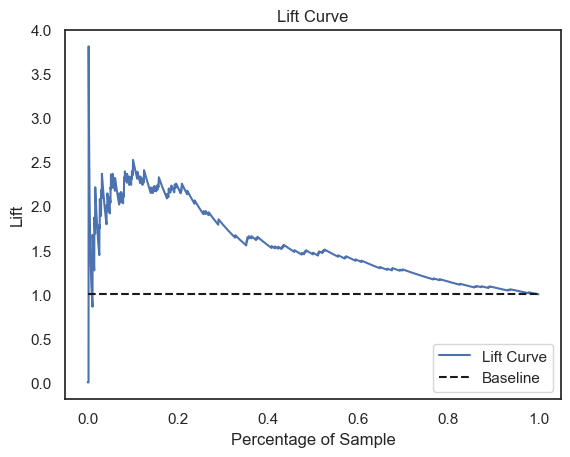

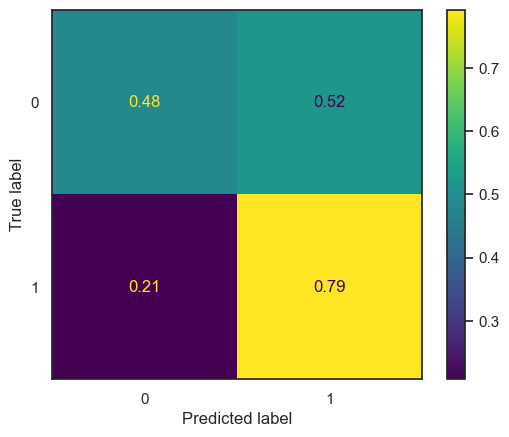

In [73]:
th = 0.42
y_probas = xgb_model.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

xgb_eval_final = ModelEvaluator(xgb_model, X_val, y_val, th=th)
xgb_eval_final.evaluate()

xgb_eval_final.plot_lift()

xgb_eval_final.plot_confusion_matrix(normalize='true')

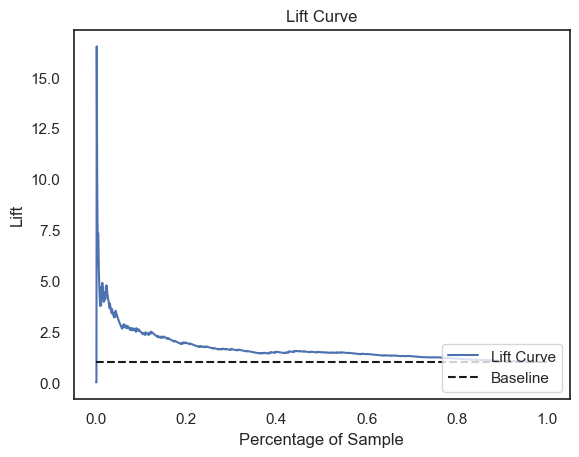

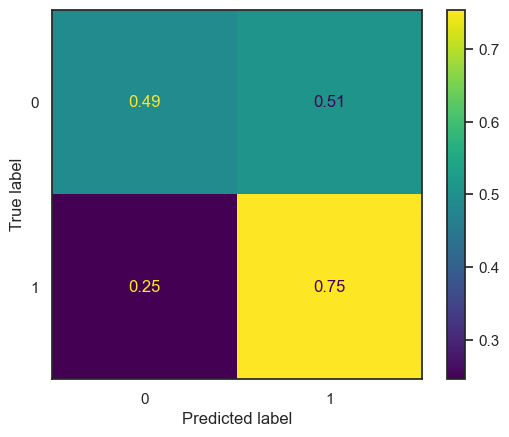

In [74]:
th = 0.42
y_probas = xgb_model.predict_proba(X_test)[:, 1]

# Classify data into low, medium, and high categories
ypred_low = (y_probas <= th).astype(int)
ypred_medium = (y_probas > th) & (y_probas <= 0.7).astype(int)
ypred_high = (y_probas > 0.7).astype(int)


rf_eval = ModelEvaluator(xgb_model, X_test, y_test, th=th)
rf_eval.evaluate()

rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

# Seleção do modelo

O XGboost adequou melhor no dataset de validação e dataset de teste.

## Conjunto de validação

### Random Forest

#### Val

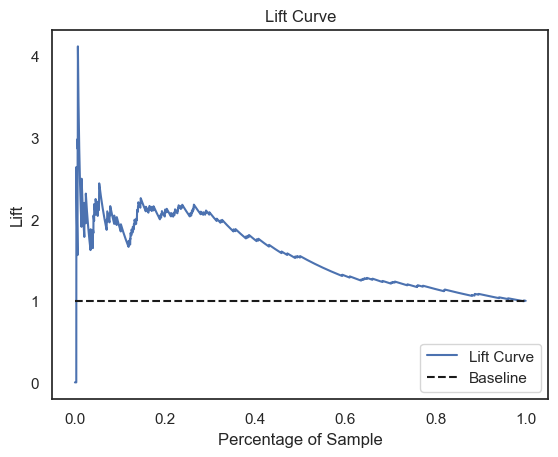

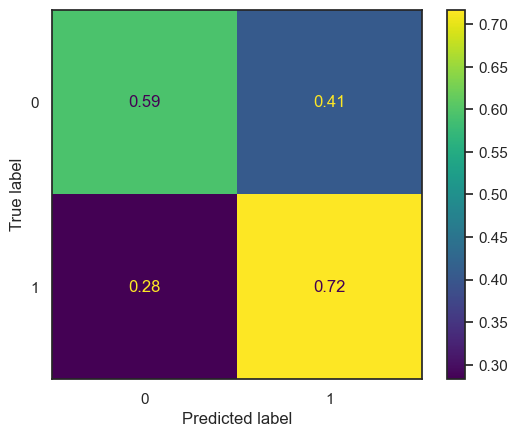

In [79]:
rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.42)

rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

### XGBoost

#### Val

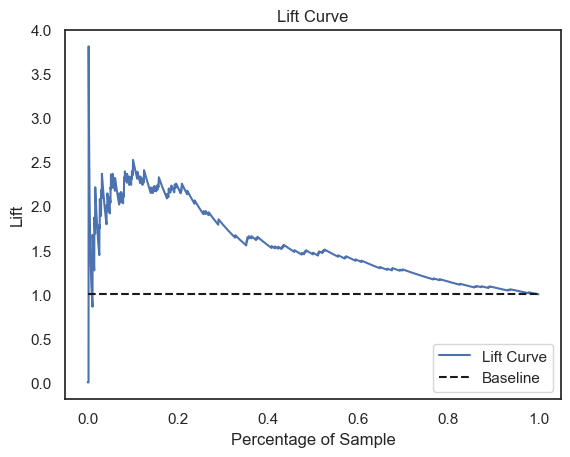

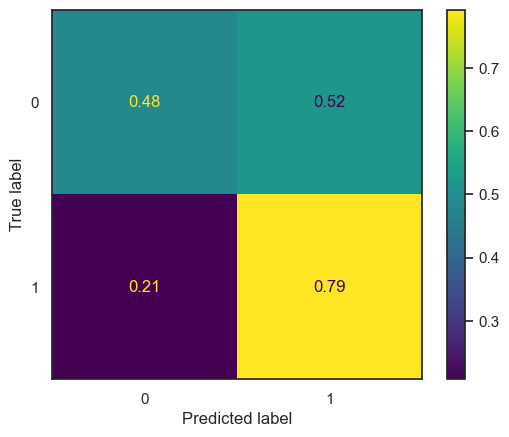

In [81]:
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.42)

xgb_eval.plot_lift()

xgb_eval.plot_confusion_matrix(normalize='true')

## Conjunto de Teste

### Random Forest

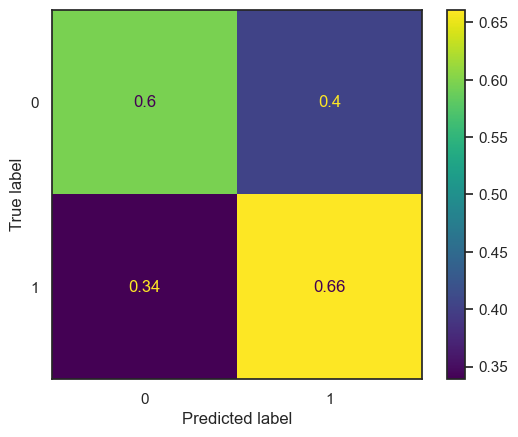

In [82]:
rf_eval = ModelEvaluator(rf_model, X_test, y_test, th=0.42)
rf_eval.plot_confusion_matrix(normalize='true')

### XGBoost

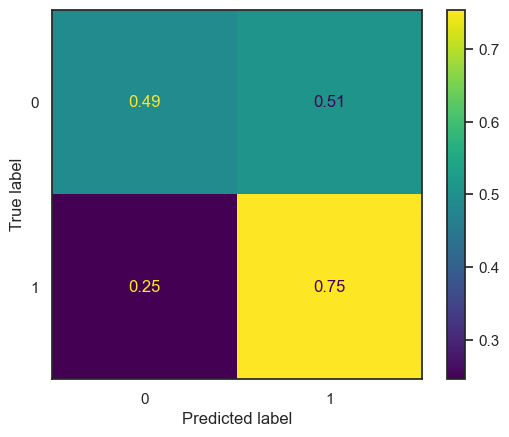

In [83]:
xgb_eval = ModelEvaluator(xgb_model, X_test, y_test, th=0.42)
xgb_eval.plot_confusion_matrix(normalize='true')

# Análise Comparativa dos Modelos

## Resultados em Teste

## Justificativa de Escolha: XGBoost

1. **Performance Superior**: O modelo identifica 75% das conversões reais vs 66% da Random Forest, representando uma diferença significativa de 90 conversões adicionais a cada 1000 casos.

2. **Estabilidade**: Apresentou menor variação entre validação e teste:
  - Classe positiva: ±0.04 (vs ±0.06 RF)
  - Classe negativa: ±0.01 (similar à RF)

3. **Trade-off Aceitável**: O aumento de 11% nos falsos positivos é compensado pela captura de 9% a mais de conversões reais, especialmente considerando que:
  - O custo de perder uma conversão (receita) > custo operacional de abordar falsos positivos
  - O dataset é naturalmente desbalanceado (97% classe 0, 3% classe 1)

**Conclusão**: O XGBoost demonstra melhor capacidade de generalização e performance superior na métrica principal (identificação de conversões), justificando sua escolha para implementação em produção.```

In [ ]:
# Análise de Performance: Validação vs Teste

## Comparativo dos Conjuntos

### Validação
Random Forest:
- True Positive Rate: 72%
- False Positive Rate: 41%

XGBoost:
- True Positive Rate: 79%
- False Positive Rate: 52%

### Teste
Random Forest:
- True Positive Rate: 66%
- False Positive Rate: 40%

XGBoost:
- True Positive Rate: 75%
- False Positive Rate: 51%

## Recomendação

Para apresentação dos resultados, recomendo utilizar os números do conjunto de teste pelos seguintes motivos:

1. **Maior Confiabilidade**: O conjunto de teste representa dados nunca vistos pelo modelo, simulando melhor o cenário real de produção.

2. **Conservadorismo**: Os resultados em teste são ligeiramente inferiores aos de validação, fornecendo uma estimativa mais conservadora e realista do desempenho esperado.

3. **Transparência**: Apresentar métricas de teste demonstra maior rigor metodológico e transparência na avaliação do modelo.

**Conclusão**: Embora os resultados de validação sejam mais otimistas, os números de teste (XGBoost: 75% True Positive Rate) fornecem maior credibilidade à apresentação e melhor estimativa do desempenho real esperado em produção.

Precision: dos clientes que previmos como PRO, quantos realmente são

Recall: dos clientes que realmente são PRO, quantos conseguimos identificar

F1 : Bom para avaliar o trade-off entre falsos positivos e falsos negativos. Dá mais peso para a classe minoritária (PRO)

Lift

Mostra quantas vezes seu modelo é melhor que uma seleção aleatória
Muito útil para problemas de negócio como este


Vamos analisar o significado de cada métrica no contexto do Cartola FC para tomar essa decisão:

**Precision (Precisão)**
- Dos clientes que o modelo previu como potenciais PRO, quantos realmente se tornaram PRO
- Alta precision significa menos desperdício de recursos em ações de marketing
- Fórmula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)

**Recall (Revocação/Sensibilidade)**
- Dos clientes que realmente se tornaram PRO, quantos conseguimos identificar
- Alto recall significa capturar a maior quantidade possível de clientes potenciais
- Fórmula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

Para o Cartola FC, eu recomendaria **priorizar Recall** pelos seguintes motivos:

1. **Modelo de Negócio**
   - Cliente PRO gera receita recorrente
   - Perder um potencial cliente PRO (falso negativo) significa perder receita garantida
   - O custo de abordar um cliente free que não se converte (falso positivo) é relativamente baixo

2. **Estratégia de Marketing**
   - Melhor abordar mais clientes potenciais, mesmo que alguns não convertam
   - O custo de comunicação/campanha provavelmente é baixo (emails, notificações no app)
   - Você pode criar diferentes níveis de ações baseado no score de propensão

3. **Competitividade do Mercado**
   - Se um cliente com alto potencial não é abordado, ele pode:
     - Continuar como free indefinidamente
     - Migrar para concorrentes
     - Perder interesse no produto

4. **Aprendizado do Negócio**
   - Alto recall permite entender melhor o comportamento dos diferentes perfis
   - Ajuda a refinar futuras campanhas e o próprio modelo

Recomendações práticas:

1. Use threshold mais baixo na classificação para aumentar o recall
2. Monitore o lift nas diferentes faixas de score
3. Crie níveis de ações diferentes baseado no score:
   - Top 10%: ação mais agressiva
   - 10-30%: ação moderada
   - 30-50%: ação leve

Você concorda com essa análise? Tem alguma informação adicional sobre o custo de aquisição ou valor do cliente PRO que devemos considerar?